# Импорт данных

Тут импортирую нужные библиотеки и загружаю данные из архива. (Нужно просто загрузить архив на гугл диск и все будет работать)

In [ ]:
import os
import re
import zipfile
from datetime import timedelta

import numpy as np
import pandas as pd
import plotly.express as px
from collections import Counter

!pip install catboost
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score

import nltk
from nltk import pos_tag, word_tokenize

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Mounted at /content/drive


In [ ]:
zip_path = '/content/drive/MyDrive/train_dataset_soc_dem_train.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/train_dataset')
csv_folder = '/content/train_dataset'

csv_files = ['video_info_v2.csv', 'train_targets.csv', 'train_events.csv', 'all_events.csv']

video_info_df = pd.read_csv(f'{csv_folder}/video_info_v2.csv')
train_targets_df = pd.read_csv(f'{csv_folder}/train_targets.csv')
train_events_df = pd.read_csv(f'{csv_folder}/train_events.csv')
all_events_df = pd.read_csv(f'{csv_folder}/all_events.csv')

# Feature engineering

Тут достаточно объемная генерация фичей. В итоге получаем датасет final_df, в котором содержится информация о каждом пользователе в тесте.

In [ ]:
events = pd.merge(train_events_df, video_info_df, how = 'left', on = 'rutube_video_id')
timezone_offsets = {
    'Tatarstan Republic': 0,
    'Bashkortostan Republic': 2,
    'Novosibirsk Oblast': 4,
    'Moscow': 0,
    'Moscow Oblast': 0,
    'Omsk Oblast': 3,
    'Chuvashia': 0,
    'Krasnoyarsk Krai': 4,
    'Krasnoyarskiy': 4,
    'Chelyabinsk': 2,
    'Kamchatka': 9,
    'Nizhny Novgorod Oblast': 0,
    'Krasnodar Krai': 0,
    'Volgograd Oblast': 0,
    'Kaliningrad Oblast': -1,
    'Kuzbass': 4,
    'Stavropol Kray': 0,
    'Samara Oblast': 1,
    'Amur Oblast': 6,
    'Sverdlovsk Oblast': 2,
    'St.-Petersburg': 0,
    'Yamalo-Nenets': 2,
    'Orenburg Oblast': 2,
    'Khanty-Mansia': 2,
    'Kaluga Oblast': 0,
    'Tomsk Oblast': 4,
    'Novgorod Oblast': 0,
    'Arkhangelskaya': 0,
    'North Ossetia–Alania': 0,
    'Kursk Oblast': 0,
    "Leningradskaya Oblast'": 0,
    'Ivanovo Oblast': 0,
    'Altay Kray': 4,
    'Kurgan Oblast': 2,
    'Kostroma Oblast': 0,
    'Bryansk Oblast': 0,
    'Dagestan': 0,
    'Lipetsk Oblast': 0,
    'Vladimir Oblast': 0,
    'Kirov Oblast': 0,
    'Khabarovsk': 7,
    'Tambov Oblast': 0,
    'Chukotka': 9,
    'Voronezh Oblast': 0,
    'Sverdlovsk': 2,
    'Tula Oblast': 0,
    'Krasnodarskiy': 0,
    'Irkutsk Oblast': 5,
    'Saratov Oblast': 0,
    'Khakasiya Republic': 4,
    'Penza': 0,
    'Perm Krai': 2,
    'Oryol oblast': 0,
    'Vladimir': 0,
    'Smolensk Oblast': 0,
    'Penza Oblast': 0,
    'Mordoviya Republic': 0,
    'Tyumen’ Oblast': 2,
    'Sakha': 8,
    'Primorye': 7,
    'Zabaykalskiy (Transbaikal) Kray': 6,
    'Vologda Oblast': 0,
    'Yaroslavl Oblast': 0,
    'Crimea': 0,
    'Rostov': 0,
    'Ryazan Oblast': 0,
    'Perm': 2,
    'Chechnya': 0,
    'Udmurtiya Republic': 1,
    'Tver Oblast': 0,
    'Buryatiya Republic': 5,
    'Belgorod Oblast': 0,
    'Kaluga': 0,
    'Astrakhan Oblast': 0,
    'Karelia': 0,
    'Murmansk': 0,
    'Adygeya Republic': 0,
    'Kemerovo Oblast': 4,
    'Mariy-El Republic': 0,
    'Kursk': 0,
    'Saratovskaya Oblast': 0,
    'Sakhalin Oblast': 8,
    'Ivanovo': 0,
    'Tyumen Oblast': 2,
    'Stavropol’ Kray': 0,
    'Voronezj': 0,
    'Karachayevo-Cherkesiya Republic': 0,
    'Kabardino-Balkariya Republic': 0,
    'Ulyanovsk': 1,
    'North Ossetia': 0,
    'Komi': 0,
    'Smolensk': 0,
    'Tver’ Oblast': 0,
    'Sebastopol City': 0,
    'Pskov Oblast': 0,
    'Tula': 0,
    'Orel Oblast': 0,
    'Jaroslavl': 0,
    'Tambov': 0,
    'Kalmykiya Republic': 0,
    'Primorskiy (Maritime) Kray': 7,
    'Altai': 4,
    'Magadan Oblast': 8,
    'Vologda': 0,
    'Tyva Republic': 4,
    'Nenets': 2,
    'Smolenskaya Oblast’': 0,
    'Jewish Autonomous Oblast': 7,
    'Astrakhan': 0,
    'Ingushetiya Republic': 0,
    'Kirov': 0,
    'Transbaikal Territory': 6,
    'Omsk': 3,
    'Kaliningrad': -1,
    'Stavropol Krai': 0,
    'Arkhangelsk Oblast': 0
}

events['event_timestamp'] = pd.to_datetime(events['event_timestamp'])

events['duration'] = pd.to_numeric(events['duration'], errors='coerce')
events['total_watchtime'] = pd.to_numeric(events['total_watchtime'], errors='coerce')

def adjust_timestamp(row):
    offset = timezone_offsets.get(row['region'], 0)
    return row['event_timestamp'] + timedelta(hours=offset)

events['event_timestamp_local'] = events.apply(adjust_timestamp, axis=1)

events['ua_os'].fillna(events['ua_os'].mode()[0], inplace=True)

In [ ]:
agg_funcs = {
    'total_watchtime': ['sum', 'mean', 'max', 'median', 'std'],  # Общее, среднее, максимальное время просмотра
    'rutube_video_id': 'count',  # Количество просмотренных видео
    'category': [lambda x: x.mode()[0], lambda x: ' '.join(x)],
    'duration': ['sum', 'mean', 'median', 'std'],  # Общее и среднее время длительности видео
    'title': lambda x: ' '.join(x),  # Сложение заголовков видео
    'region': [lambda x: x.mode()[0], lambda x: x.nunique()],  # Мода по столбцу region
    'ua_os': [lambda x: x.mode()[0], lambda x: x.nunique()],
    'ua_client_name': [lambda x: x.mode()[0], lambda x: x.nunique()],

}

user_history = events.groupby('viewer_uid').agg(agg_funcs)

user_history.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in user_history.columns]

# Подсчет % соотношения ua_device_type
device_counts = events.groupby(['viewer_uid', 'ua_device_type']).size().unstack(fill_value=0)
device_percentage = device_counts.div(device_counts.sum(axis=1), axis=0).fillna(0)
device_percentage.columns = [f'device_percentage_{col}' for col in device_percentage.columns]

# Подсчет % соотношения ua_client_type
client_counts = events.groupby(['viewer_uid', 'ua_client_type']).size().unstack(fill_value=0)
client_percentage = client_counts.div(client_counts.sum(axis=1), axis=0).fillna(0)
client_percentage.columns = [f'client_percentage_{col}' for col in client_percentage.columns]

# Подсчет % видео в каждой категории
category_counts = events.groupby(['viewer_uid', 'category']).size().unstack(fill_value=0)
category_percentage = category_counts.div(category_counts.sum(axis=1), axis=0).fillna(0)
category_percentage.columns = [f'category_percentage_{col}' for col in category_percentage.columns]

total_watchtime_per_user = events.groupby('viewer_uid')['total_watchtime'].sum()
category_watchtime_per_user = events.groupby(['viewer_uid', 'category'])['total_watchtime'].sum()
category_watchtime_ratio = category_watchtime_per_user.div(total_watchtime_per_user, level='viewer_uid').fillna(0)
category_watchtime_ratio = category_watchtime_ratio.unstack(fill_value=0)
category_watchtime_ratio.columns = [f'category_watchtime_ratio_{col}' for col in category_watchtime_ratio.columns]

final_df = pd.merge(user_history, train_targets_df, on='viewer_uid', how='left')
final_df = final_df.join(category_watchtime_ratio, on='viewer_uid')
final_df = final_df.join(device_percentage, on='viewer_uid')
final_df = final_df.join(client_percentage, on='viewer_uid')
final_df = final_df.join(category_percentage, on='viewer_uid')

final_df['mean_len'] = len(final_df['title_<lambda>']) / final_df['rutube_video_id_count']
final_df['mean_upper'] = final_df['title_<lambda>'].apply(lambda x: sum(1 for c in x if c.isupper())) / final_df['rutube_video_id_count']


def top_50_words(titles):
    words = titles.lower().split()
    word_counts = Counter(words)
    most_common_words = word_counts.most_common(10)
    return ' '.join([word for word, _ in most_common_words])

def top_5000_words(titles):
    words = titles.lower().split()
    word_counts = Counter(words)
    most_common_words = word_counts.most_common(1000)
    return ' '.join([word for word, _ in most_common_words])

def top_500_words(titles):
    words = titles.lower().split()
    word_counts = Counter(words)
    most_common_words = word_counts.most_common(100)
    return ' '.join([word for word, _ in most_common_words])


final_df['top_50_frequent_words'] = final_df['title_<lambda>'].apply(top_50_words)
final_df['top_500_frequent_words'] = final_df['title_<lambda>'].apply(top_500_words)
final_df['top_5000_frequent_words'] = final_df['title_<lambda>'].apply(top_5000_words)


top_100_videos = (train_events_df.groupby('rutube_video_id')['viewer_uid']
                  .nunique()
                  .sort_values(ascending=False)
                  .head(500)
                  .index)


top_videos_events = train_events_df[train_events_df['rutube_video_id'].isin(top_100_videos)]


user_top_videos = (top_videos_events
                   .assign(watched=1)
                   .pivot_table(index='viewer_uid',
                                columns='rutube_video_id',
                                values='watched',
                                fill_value=0))

final_df = final_df.merge(user_top_videos, on='viewer_uid', how='left').fillna(0)

final_df['unique_words'] = final_df['title_<lambda>'].apply(lambda x: ' '.join(set(x.split())))

In [ ]:
def extract_additional_text_features(df):
    # Количество уникальных слов в заголовке
    df['title_unique_word_count'] = df['title'].apply(lambda x: len(set(x.split())) if isinstance(x, str) else 0)

    # Наличие специальных символов (например, '!', '?') в заголовке
    df['title_has_special_char'] = df['title'].apply(lambda x: int(bool(re.search(r'[!?]', x))) if isinstance(x, str) else 0)

    # Соотношение заглавных букв к общему количеству букв в заголовке
    df['title_upper_ratio'] = df['title'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if isinstance(x, str) and len(x) > 0 else 0)

    # Первое и последнее слово заголовка
    df['first_word'] = df['title'].apply(lambda x: x.split()[0] if len(x.split()) > 0 else '')
    df['last_word'] = df['title'].apply(lambda x: x.split()[-1] if len(x.split()) > 0 else '')

    # Количество заглавных слов в заголовке
    df['title_upper_word_count'] = df['title'].apply(lambda x: sum(1 for word in x.split() if word.isupper()) if isinstance(x, str) else 0)

    # Средняя длина слов в заголовке
    df['title_avg_word_length'] = df['title'].apply(lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0)



    # Наличие иностранных слов (например, английских)
    df['title_foreign_words'] = df['title'].apply(lambda x: int(any(re.search(r'[a-zA-Z]', word) for word in x.split())) if isinstance(x, str) else 0)


    return df

# Применяем функции для извлечения дополнительных текстовых фичей
video_info_df = extract_additional_text_features(video_info_df)

# Объединяем данные с events
events_with_title = pd.merge(events, video_info_df[['rutube_video_id', 'title_unique_word_count', 'title_has_special_char',
                                                    'title_upper_ratio', 'first_word', 'last_word', 'title_upper_word_count',
                                                    'title_avg_word_length',
                                                    'title_foreign_words']],
                             on='rutube_video_id', how='left')

text_agg_funcs = {
    'title_unique_word_count': ['sum', 'mean'],  # Количество уникальных слов
    'title_has_special_char': 'mean',  # Наличие специальных символов
    'title_upper_ratio': 'mean',  # Соотношение заглавных букв
    'title_upper_word_count': ['sum', 'mean'],  # Количество заглавных слов
    'title_avg_word_length': 'mean',  # Средняя длина слов
    'title_foreign_words': 'sum',  # Количество заголовков с иностранными словами
}

user_text_features = events_with_title.groupby('viewer_uid').agg(text_agg_funcs)
user_text_features.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in user_text_features.columns]

final_df = final_df.join(user_text_features, on='viewer_uid')

events['day_of_week'] = events['event_timestamp_local'].dt.day_name()  # Extract day of the week
events['hour'] = events['event_timestamp_local'].dt.hour  # Extract hour of the day
events['time_of_day'] = pd.cut(events['hour'], bins=[0, 6, 12, 18, 24], labels=['night', 'morning', 'day', 'evening'], right=False)

common_time_of_day = events.groupby('viewer_uid')['time_of_day'].agg(lambda x: x.mode()[0])

final_df = final_df.join(common_time_of_day.rename('common_time_of_day'), on='viewer_uid')

# получили кластеры в другом ноутбуке с помощью векторов заголовков
clusters = pd.read_csv('/content/drive/MyDrive/id_clusters.csv')
clusters = clusters.drop(columns = ['Unnamed: 0'])
final_df = final_df.merge(clusters, on='viewer_uid', how='left')
final_df.head(5)

,viewer_uid,total_watchtime_sum,total_watchtime_mean,total_watchtime_max,total_watchtime_median,total_watchtime_std,rutube_video_id_count,category_<lambda_0>,category_<lambda_1>,duration_sum,...,common_time_of_day,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10
0,10000001,68757,3618.789474,6932,4003.0,1864.664569,19,Телепередачи,Телепередачи Телепередачи Телепередачи Телепер...,92289160,...,evening,0,1,3,2,1,0,2,2,3
1,10000002,15220,1691.111111,6688,1210.0,1913.552158,9,Сериалы,Сериалы Сериалы Сериалы Сериалы Сериалы Сериал...,24335291,...,evening,0,1,0,0,4,2,4,4,8
2,10000004,16501,1375.083333,4778,613.0,1419.391064,12,Наука,Наука Технологии и интернет Обучение Обучение ...,27242103,...,morning,1,0,2,1,0,1,5,8,6
3,10000005,212,212.000000,212,212.0,0.000000,1,Технологии и интернет,Технологии и интернет,525092,...,day,1,2,1,3,3,4,1,1,7
4,10000006,971,971.000000,971,971.0,0.000000,1,Аниме,Аниме,1181825,...,evening,1,0,2,1,2,6,6,3,2


In [ ]:
print(final_df.shape)
final_df.head()

(180012, 633)


,viewer_uid,total_watchtime_sum,total_watchtime_mean,total_watchtime_max,total_watchtime_median,total_watchtime_std,rutube_video_id_count,category_<lambda_0>,category_<lambda_1>,duration_sum,...,common_time_of_day,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10
0,10000001,68757,3618.789474,6932,4003.0,1864.664569,19,Телепередачи,Телепередачи Телепередачи Телепередачи Телепер...,92289160,...,evening,0,1,3,2,1,0,2,2,3
1,10000002,15220,1691.111111,6688,1210.0,1913.552158,9,Сериалы,Сериалы Сериалы Сериалы Сериалы Сериалы Сериал...,24335291,...,evening,0,1,0,0,4,2,4,4,8
2,10000004,16501,1375.083333,4778,613.0,1419.391064,12,Наука,Наука Технологии и интернет Обучение Обучение ...,27242103,...,morning,1,0,2,1,0,1,5,8,6
3,10000005,212,212.000000,212,212.0,0.000000,1,Технологии и интернет,Технологии и интернет,525092,...,day,1,2,1,3,3,4,1,1,7
4,10000006,971,971.000000,971,971.0,0.000000,1,Аниме,Аниме,1181825,...,evening,1,0,2,1,2,6,6,3,2


In [ ]:
top_100_videos
df_videos = pd.DataFrame(top_100_videos, columns=['rutube_video_id'])
df_videos.to_csv('/content/drive/MyDrive/top_100_videos.csv', index=False)

In [ ]:
cat_features=['category_<lambda_0>', 'region_<lambda_0>', 'ua_client_name_<lambda_0>', 'ua_os_<lambda_0>', 'common_time_of_day',
              'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10']

text_features = ['title_<lambda>', 'top_50_frequent_words','top_500_frequent_words', 'category_<lambda_1>', 'top_5000_frequent_words', 'unique_words']

# Обучение модели

Тут обучение уже лучшей модели. Две модели CatBoost классификаторы.

In [ ]:
# final_df = pd.read_csv('/content/drive/MyDrive/final_df_for_learnong3.csv')
# X = final_df.drop(columns=['age', 'sex', 'age_class', 'Unnamed: 0'])

# y = final_df[['age', 'sex', 'age_class']]

In [ ]:
X = final_df.drop(columns=['age', 'sex', 'age_class'])

y = final_df[['age', 'sex', 'age_class']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=228)

y_age_class_train, y_age_class_test = y_train['age_class'], y_test['age_class']
y_sex_train, y_sex_test = y_train['sex'], y_test['sex']

model_age_class = CatBoostClassifier(cat_features = cat_features, text_features = text_features, verbose=100, task_type='GPU',
                                     learning_rate=0.051431,
                                     depth=4,
                                     iterations=5262,
                                     l2_leaf_reg=8.737,
                                     )

model_sex = CatBoostClassifier(cat_features = cat_features, text_features = text_features, verbose=100, task_type='GPU',
                                     learning_rate=0.051431,
                                     depth=4,
                                     iterations=5262,
                                     l2_leaf_reg=8.737,
                               )

# Для уверенности в результате также делали кросс валидацию, метрики такие же

# cv_scores_age_class = cross_val_score(model_age_class, X_train, y_age_class_train, cv=5, scoring='f1_weighted')
# print('CV F1 Score for age class classification:', cv_scores_age_class.mean())
# cv_scores_sex = cross_val_score(model_sex, X_train, y_sex_train, cv=5, scoring='accuracy')
# print('CV Accuracy for sex classification:', cv_scores_sex.mean())

model_age_class.fit(X_train, y_age_class_train)
model_sex.fit(X_train, y_sex_train)

y_age_class_pred = model_age_class.predict(X_test)
y_sex_pred = model_sex.predict(X_test)

print('\nage_class f1:',  f1_score(y_age_class_pred, y_age_class_test, average='weighted'),
      '\nage_sex acc:', accuracy_score(y_sex_pred, y_sex_test),
      '\nИтоговая метрика: ', 0.7 * f1_score(y_age_class_pred, y_age_class_test, average='weighted') + 0.3 * accuracy_score(y_sex_pred, y_sex_test))

0:	learn: 1.3622070	total: 311ms	remaining: 27m 15s
100:	learn: 1.0691640	total: 5.51s	remaining: 4m 41s
200:	learn: 1.0562398	total: 10s	remaining: 4m 11s
300:	learn: 1.0506288	total: 14.2s	remaining: 3m 54s
400:	learn: 1.0463573	total: 18.3s	remaining: 3m 42s
500:	learn: 1.0433850	total: 21.9s	remaining: 3m 27s
600:	learn: 1.0412533	total: 25.3s	remaining: 3m 16s
700:	learn: 1.0393225	total: 30.4s	remaining: 3m 17s
800:	learn: 1.0374991	total: 35.4s	remaining: 3m 16s
900:	learn: 1.0358577	total: 39.6s	remaining: 3m 11s
1000:	learn: 1.0342999	total: 43.5s	remaining: 3m 5s
1100:	learn: 1.0327861	total: 47.5s	remaining: 2m 59s
1200:	learn: 1.0314322	total: 51.5s	remaining: 2m 54s
1300:	learn: 1.0301497	total: 55.6s	remaining: 2m 49s
1400:	learn: 1.0288896	total: 59.6s	remaining: 2m 44s
1500:	learn: 1.0277582	total: 1m 3s	remaining: 2m 39s
1600:	learn: 1.0265760	total: 1m 7s	remaining: 2m 34s
1700:	learn: 1.0255803	total: 1m 11s	remaining: 2m 30s
1800:	learn: 1.0244932	total: 1m 15s	rema

Достанем и визуализируем важность фичей для модели.

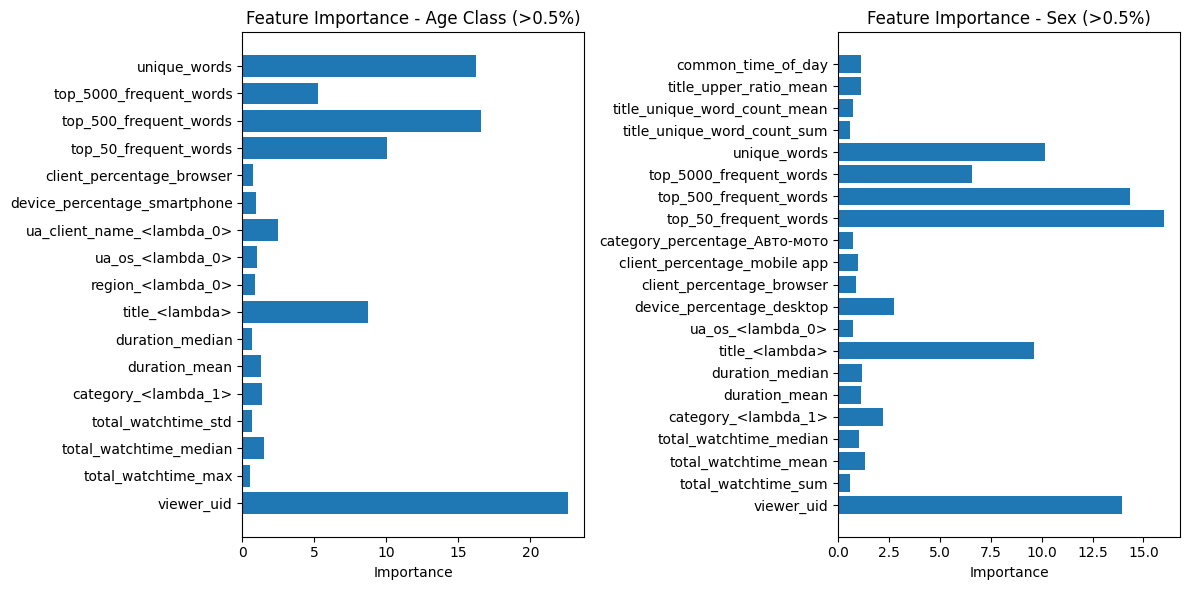

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Порог важности в процентах
threshold = 0.5

# Получаем feature importance для обеих моделей
importance_age_class = model_age_class.get_feature_importance()
importance_sex = model_sex.get_feature_importance()

# Имя фичей
feature_names = X_train.columns

# Фильтруем признаки по важности для model_age_class
mask_age_class = importance_age_class > threshold
filtered_importance_age_class = importance_age_class[mask_age_class]
filtered_feature_names_age_class = np.array(feature_names)[mask_age_class]

# Фильтруем признаки по важности для model_sex
mask_sex = importance_sex > threshold
filtered_importance_sex = importance_sex[mask_sex]
filtered_feature_names_sex = np.array(feature_names)[mask_sex]

# Построение графика
plt.figure(figsize=(12, 6))

# График для model_age_class
plt.subplot(1, 2, 1)
plt.barh(filtered_feature_names_age_class, filtered_importance_age_class)
plt.title("Feature Importance - Age Class (>{}%)".format(threshold))
plt.xlabel("Importance")

# График для model_sex
plt.subplot(1, 2, 2)
plt.barh(filtered_feature_names_sex, filtered_importance_sex)
plt.title("Feature Importance - Sex (>{}%)".format(threshold))
plt.xlabel("Importance")

plt.tight_layout()
plt.show()


In [ ]:
model_age_class = CatBoostClassifier(cat_features = cat_features, text_features = text_features, verbose=100, task_type='GPU',
                                     learning_rate=0.051431,
                                     depth=4,
                                     iterations=5262,
                                     l2_leaf_reg=8.737,
                                     )

model_sex = CatBoostClassifier(cat_features = cat_features, text_features = text_features, verbose=100, task_type='GPU',
                                     learning_rate=0.051431,
                                     depth=4,
                                     iterations=5262,
                                     l2_leaf_reg=8.737,
                               )
model_sex.load_model('/content/drive/MyDrive/model_sex1.pt')

model_age_class.load_model('/content/drive/MyDrive/model_age_class.pt')

# Перебор гиперпараметров

Стандартный перебор гиперпараметров с помощью optuna

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.9 MB/s eta 0:00:00


In [ ]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

In [ ]:
def objective_age_class(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.1)
    depth = trial.suggest_int('depth', 4, 10)
    iterations = trial.suggest_int('iterations', 1000, 8000)
    l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1, 10)

    model = CatBoostClassifier(
        cat_features=cat_features,
        text_features=text_features,
        verbose=0,
        task_type='GPU',
        learning_rate=learning_rate,
        depth=depth,
        iterations=iterations,
        l2_leaf_reg=l2_leaf_reg,
    )

    model.fit(X_train, y_age_class_train)
    y_pred = model.predict(X_test)
    score = f1_score(y_pred, y_age_class_test, average='weighted')

    return score

study_age_class = optuna.create_study(direction='maximize')
study_age_class.optimize(objective_age_class, n_trials=100)

print("Best parameters for age class model:", study_age_class.best_params)
print("Best F1 Score for age class model:", study_age_class.best_value)

[I 2024-09-28 19:20:48,231] A new study created in memory with name: no-name-ff9bdaaa-e817-46d6-aece-7902e3de4858
<ipython-input-24-cc200e8b18f2>:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.1)
<ipython-input-24-cc200e8b18f2>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1, 10)
[W 2024-09-28 19:21:10,572] Trial 0 failed with parameters: {'learning_rate': 0.039687335102877544, 'depth': 10, 'iterations': 6587, 'l2_leaf_reg': 6.933410835705873} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/usr/lo

KeyboardInterrupt: 

In [ ]:
def objective_sex(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.1)
    depth = trial.suggest_int('depth', 4, 10)
    iterations = trial.suggest_int('iterations', 100, 8000)
    l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1, 10)

    model = CatBoostClassifier(
        cat_features=cat_features,
        text_features=text_features,
        verbose=0,
        task_type='GPU',
        learning_rate=learning_rate,
        depth=depth,
        iterations=iterations,
        l2_leaf_reg=l2_leaf_reg,
    )

    model.fit(X_train, y_sex_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_pred, y_sex_test)

    return score

study_sex = optuna.create_study(direction='maximize')
study_sex.optimize(objective_sex, n_trials=100)

print("Best parameters for sex model:", study_sex.best_params)
print("Best Accuracy for sex model:", study_sex.best_value)

[I 2024-09-28 19:21:16,438] A new study created in memory with name: no-name-a2d4d16d-40d4-4a55-b411-98aa7326a13f
<ipython-input-25-02cad6f26390>:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.1)
<ipython-input-25-02cad6f26390>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1, 10)
[I 2024-09-28 19:24:03,805] Trial 0 finished with value: 0.7655816020442173 and parameters: {'learning_rate': 0.01272829353361352, 'depth': 4, 'iterations': 7128, 'l2_leaf_reg': 4.108888254511977}. Best is trial 0 with value: 0.7655816020442173.
<ipython-input-25-02cad6f2

# Другие архитектуры

Пробовали также делать третий catboost на предикт возраста и добавление его предикта как фичу в 2 других CatBoost.

Пробовали обучать LightGBM с векторами текста и без них. Также с разными типами encodingа категориальных признаков.

Пробовали TabNet, но не сильно оптимальная модель под задачу.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

X = final_df.drop(columns=['age', 'sex', 'age_class'])
y = final_df[['age', 'sex', 'age_class']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=228)
y_reg_train, y_reg_test = y_train['age'], y_test['age']
model_age = CatBoostRegressor(cat_features = cat_features, text_features = text_features, verbose=100, task_type='GPU')
model_age.fit(X_train, y_reg_train)
y_pred_reg = model_age.predict(X_test)
print('MSE_age: ', mean_squared_error(y_pred_reg, y_reg_test))
pred_for_train = model_age.predict(X_train)

X_train = X_train.assign(predicted_age=pred_for_train)
X_test = X_test.assign(predicted_age=y_pred_reg)

y_age_class_train, y_age_class_test = y_train['age_class'], y_test['age_class']
y_sex_train, y_sex_test = y_train['sex'], y_test['sex']

model_age_class = CatBoostClassifier(cat_features = cat_features, text_features = text_features, verbose=100, task_type='GPU')
model_sex = CatBoostClassifier(cat_features = cat_features, text_features = text_features, verbose=100, task_type='GPU')

model_age_class.fit(X_train, y_age_class_train)
model_sex.fit(X_train, y_sex_train)

y_age_class_pred = model_age_class.predict(X_test)
y_sex_pred = model_sex.predict(X_test)


print('\nage_class f1:',  f1_score(y_age_class_pred, y_age_class_test, average='weighted'),
      '\nage_sex acc:', accuracy_score(y_sex_pred, y_sex_test),
      '\nИтоговая метрика: ', 0.7 * f1_score(y_age_class_pred, y_age_class_test, average='weighted') + 0.3 * accuracy_score(y_sex_pred, y_sex_test))

LightGBM

In [ ]:
!pip install category_encoders
from category_encoders import TargetEncoder
import lightgbm as lgb

In [ ]:
X = final_df.drop(columns=['age', 'sex', 'age_class'])
X = X.drop(columns = text_features)
y = final_df[['age', 'sex', 'age_class']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train['sex'] = y_train['sex'].map({'male': 1, 'female': 0})
y_test['sex'] = y_test['sex'].map({'male': 1, 'female': 0})

encoder_age_class = TargetEncoder(cols=cat_features)
X_train_encoded_age = encoder_age_class.fit_transform(X_train[cat_features], y_train['age_class'])
X_test_encoded_age = encoder_age_class.transform(X_test[cat_features])

X_train_age_final = X_train.drop(columns=cat_features).join(X_train_encoded_age)
X_test_age_final = X_test.drop(columns=cat_features).join(X_test_encoded_age)

model_age_class = lgb.LGBMClassifier(num_iterations=500, learning_rate=0.1, objective='multiclass', num_class=3)

model_age_class.fit(X_train_age_final, y_train['age_class'])

y_age_class_pred = model_age_class.predict(X_test_age_final)

print('\nage_class f1:', f1_score(y_test['age_class'], y_age_class_pred, average='weighted'))


encoder_sex = TargetEncoder(cols=cat_features)
X_train_encoded_sex = encoder_sex.fit_transform(X_train[cat_features], y_train['sex'])
X_test_encoded_sex = encoder_sex.transform(X_test[cat_features])


X_train_sex_final = X_train.drop(columns=cat_features).join(X_train_encoded_sex)
X_test_sex_final = X_test.drop(columns=cat_features).join(X_test_encoded_sex)

model_sex = lgb.LGBMClassifier(num_iterations=500, learning_rate=0.1, objective='binary')
model_sex.fit(X_train_sex_final, y_train['sex'])

y_sex_pred = model_sex.predict(X_test_sex_final)

print('\nage_sex acc:', accuracy_score(y_test['sex'], y_sex_pred))

# Подбор трешхолда по количеству просмотров

Ограничиваем выборку числом просмотров и смотрим метрики, делая предикты на всей выборке (тут у нас вся выборка, поэтому метрики чуть выше).


In [ ]:
# List of thresholds that are multiples of 10
thresholds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15 ]
results = pd.DataFrame(columns=['Threshold', 'F1 Score for Age Class', 'Accuracy for Sex', 'Final Metric'])


test_combined = X.copy()
test_combined['sex'] = y['sex'].values
test_combined['age_class'] = y['age_class'].values

for threshold in thresholds:
    # Filter the data based on the threshold
    test_filtered = test_combined[test_combined.rutube_video_id_count >= threshold]

    y_age_class_filtered = test_filtered['age_class']
    y_sex_filtered = test_filtered['sex']
    X_test_filtered = test_filtered.drop(columns = ['age_class', 'sex'])

    y_age_class_pred_filtered = model_age_class.predict(X_test_filtered)
    y_sex_pred_filtered = model_sex.predict(X_test_filtered)

    f1_age_class_filtered = f1_score(y_age_class_filtered, y_age_class_pred_filtered, average='weighted')
    acc_sex_filtered = accuracy_score(y_sex_filtered, y_sex_pred_filtered)

    final_metric = 0.7 * f1_age_class_filtered + 0.3 * acc_sex_filtered

    # Print the results for the current threshold
    print(f'\nThreshold: {threshold}',
          f'\nF1 Score for Age Class: {f1_age_class_filtered}',
          f'\nAccuracy for Sex: {acc_sex_filtered}',
          f'\nFinal Metric: {0.7 * f1_age_class_filtered + 0.3 * acc_sex_filtered}')
    current_result = pd.DataFrame({
        'Threshold': [threshold],
        'F1 Score for Age Class': [f1_age_class_filtered],
        'Accuracy for Sex': [acc_sex_filtered],
        'Final Metric': [final_metric]
    })

    # Concatenate the current result with the results DataFrame
    results = pd.concat([results, current_result], ignore_index=True)
results.to_csv('/content/drive/MyDrive/results.csv', index=False)



Threshold: 0 
F1 Score for Age Class: 0.5429272833085425 
Accuracy for Sex: 0.7999411150367753 
Final Metric: 0.6200314328270123


<ipython-input-14-0361f4c05285>:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, current_result], ignore_index=True)



Threshold: 1 
F1 Score for Age Class: 0.5429272833085425 
Accuracy for Sex: 0.7999411150367753 
Final Metric: 0.6200314328270123

Threshold: 2 
F1 Score for Age Class: 0.554875241513671 
Accuracy for Sex: 0.8122568296502523 
Final Metric: 0.6320897179546453

Threshold: 3 
F1 Score for Age Class: 0.5622323438069416 
Accuracy for Sex: 0.821977156360772 
Final Metric: 0.6401557875730908

Threshold: 4 
F1 Score for Age Class: 0.5688074476877528 
Accuracy for Sex: 0.831204732133126 
Final Metric: 0.6475266330213647

Threshold: 5 
F1 Score for Age Class: 0.5739485776496416 
Accuracy for Sex: 0.8398797479331676 
Final Metric: 0.6537279287346993

Threshold: 6 
F1 Score for Age Class: 0.5783164862112207 
Accuracy for Sex: 0.846435731640931 
Final Metric: 0.6587522598401337

Threshold: 7 
F1 Score for Age Class: 0.5815235249790581 
Accuracy for Sex: 0.8520704740216936 
Final Metric: 0.6626876096918487

Threshold: 8 
F1 Score for Age Class: 0.5846070269765776 
Accuracy for Sex: 0.856688428485777

In [ ]:
results

,Threshold,F1 Score for Age Class,Accuracy for Sex,Final Metric
0,0,0.542927,0.799941,0.620031
1,1,0.542927,0.799941,0.620031
2,2,0.554875,0.812257,0.632090
3,3,0.562232,0.821977,0.640156
4,4,0.568807,0.831205,0.647527
5,5,0.573949,0.839880,0.653728
6,6,0.578316,0.846436,0.658752
7,7,0.581524,0.852070,0.662688
8,8,0.584607,0.856688,0.666231
9,9,0.586850,0.860319,0.668890


In [ ]:
px.line(results, x = 'Threshold', y = ['F1 Score for Age Class', 'Accuracy for Sex', 'Final Metric'], template = 'simple_white',
        title = 'изменение метрик с изменением минимального числа просмотров')